In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from sklearn.preprocessing import normalize

In [2]:
def getDisparity(imgL, imgR):
    
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    window_size = 5
    min_disp = -39
    num_disp = 144
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        disp12MaxDiff = 1,
        blockSize=5,
        P1=8 * 3 * window_size ** 2,    
        P2=32 * 3 * window_size ** 2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap=63
        )
    disparity = stereo.compute(image_left, image_right).astype(np.float32) / 16.0
    disparity = (disparity-min_disp)/num_disp
    return disparity
     

In [3]:
def getDisparity_StereoSGBM_WLS(imgL, imgR):
    
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    window_size = 5
    min_disp = -39
    num_disp = 144
    left_matcher = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        disp12MaxDiff = 1,
        blockSize=5,
        P1=8 * 3 * window_size ** 2,    
        P2=32 * 3 * window_size ** 2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap=63
        )
    
    right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
    
    lmbda = 80000
    sigma = 2.0
    visual_multiplier = 1.0

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    
    displ = left_matcher.compute(imgL, imgR).astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL).astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)
    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    filteredImg = np.uint8(filteredImg)
    return filteredImg

In [4]:
def getDisparity_StereoBM(imgL, imgR):
    
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    min_disp = 16
    num_disp = 128 - min_disp
    window_size = 17
    stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = window_size)
    stereo.setMinDisparity(min_disp)
    stereo.setNumDisparities(num_disp)
    stereo.setBlockSize(window_size)
    stereo.setDisp12MaxDiff(0)
    stereo.setUniquenessRatio(10)
    stereo.setSpeckleRange(32)
    stereo.setSpeckleWindowSize(100)
    
    disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    disp_map = (disp - min_disp)/num_disp
    
    return disp_map

In [5]:
def getPoses():
    poses = []
    with open("poses.txt","r") as f:
        lines = f.readlines()
        for line in lines:
            row = line.split(" ")
            row = np.array(row).astype('float64')
            poses.append(row.reshape((3, 4)))
    return poses

In [6]:
def project_points(points, colors, K, P, width, height):
    
    R = P[:, :3]
    R[:, 1] *= -1
    t = P[:, 3]
    
    dist_coeff = np.zeros((4, 1))
    projected, _ = cv2.projectPoints(points, R, t, K, dist_coeff)

    ones_row = np.ones((points.shape[0], 1))

    
    points = np.concatenate((points, ones_row), axis = 1)
    print(K.shape, P.shape, points.T.shape)
    
    camera_projected = P @ points.T
    camera_projected = camera_projected.T.astype(np.int)
    
    xy = projected.reshape(-1, 2). astype(np.int)
    mask = (
        (0 <= xy[:, 0]) & (xy[:, 0] < width) &
        (0 <= xy[:, 1]) & (xy[:, 1] < height)
    )
    
    img_coord = xy[mask]
    img_color = colors[mask]
    
    camera_color = colors
    
    return camera_projected, camera_color, img_coord, img_color

In [7]:
def reprojectImageTo3D(Q, parallax_mat):
    points_3D = Q @ parallax_mat.T
    points_3D /= points_3D[3, :]
    points_3D = points_3D[:3, :]
    points_3D = points_3D.T
    
    print(points_3D.shape)
    output = np.zeros((370, 1226, 3))
    i = 0
    j = 0
    
    for p in range(points_3D.shape[0]):
        output[i][j] = points_3D[p]
        j += 1
        
        if j >= 1226:
            j = 0
            i += 1
        
    
    print(output.shape)
    return output

In [8]:
def getImage(points, color, height, width):
    image = np.zeros((height, width, 3), dtype=color.dtype)
    image[points[:, 1], points[:, 0]] = color
    return image

In [9]:
def getParallaxMap(disparity):
    parallax_map = []
    x, y = disparity.shape
    
    for i in range(x):
        for j in range(y):
            parallax_map.append([j, i, disparity[i, j], 1])
            
    return np.array(parallax_map)

(370, 1226)


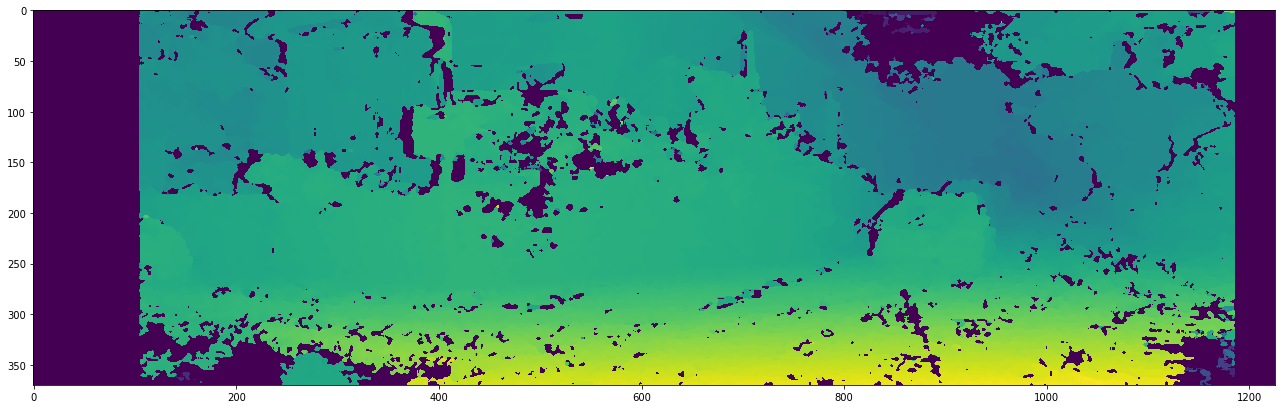

In [10]:
image_left = cv2.imread('img2/0000000461.png')
image_right = cv2.imread('img3/0000000461.png')

disparity = getDisparity(image_left, image_right)

w = disparity.shape[0]
l = disparity.shape[1]

print(disparity.shape)
plt.subplots_adjust(right=3, top=3)
plt.imshow(disparity)
plt.show()

In [11]:
focal_length = 7.070912e+02
baseline = 0.53790448812
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], [0.000000e+00, 7.070912e+02, 1.831104e+02], [0.000000e+00, 0.000000e+00, 1.000000e+00]])
poses = getPoses()

Q = np.array([
        [1, 0, 0, -l/2],
        [0, 1, 0, -w/2], 
        [0, 0, 0, focal_length],
        [0, 0, -1/baseline, 0]
    ])

all_pts = np.array([]).reshape(0,3)
all_colors = np.array([]).reshape(0,3)
for i in range(460, 481):
    image_left = cv2.imread('img2/0000000{}.png'.format(i))
    image_right = cv2.imread('img3/0000000{}.png'.format(i))

    disparity = getDisparity(image_left, image_right)
    parallax_map = getParallaxMap(disparity)
    points_3D = reprojectImageTo3D(Q, parallax_map)

    mask_map = disparity > disparity.min()

    colors = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)

    output_points = points_3D[mask_map]
    output_colors = colors[mask_map]
    
    camera_projected, camera_color, img_coords, img_color = project_points(output_points, output_colors, K, poses[i-460], l, w)
    
    all_pts = np.concatenate((all_pts, camera_projected), axis=0)
    all_colors = np.concatenate((all_colors, camera_color), axis=0)
    
    img = getImage(img_coords, img_color, w, l)
    cv2.imwrite("img" + str(i) + ".png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 355430)


/home/shashwat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shashwat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 358061)


/home/shashwat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()


(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 350507)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 351463)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 349407)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 352313)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 347400)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 343241)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 338967)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 334324)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 322440)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 316823)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 308830)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 310627)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 314263)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 318901)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 321485)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 325104)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 327434)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 332206)
(453620, 3)
(370, 1226, 3)
(3, 3) (3, 4) (4, 3

In [12]:
print(all_pts.shape)
print(np.amax(all_pts))
print(all_colors.shape)
print(np.amax(all_colors))

(7005288, 3)
121426.0
(7005288, 3)
255.0


In [13]:
mask = (
        (-4000 <= all_pts[:, 0]) & (all_pts[:, 0] < 4000) &
        (-4000 <= all_pts[:, 1]) & (all_pts[:, 1] < 4000) & 
        (-2000 <= all_pts[:, 2]) & (all_pts[:, 2] < 2000)
    )

plot_pts = all_pts[mask]
plot_pts[:, 1] *= -1
plot_colors = (all_colors[mask]/255.0).astype(float)

pcd = o3d.geometry.PointCloud()
vis = o3d.visualization.Visualizer()
pcd.points = o3d.utility.Vector3dVector(plot_pts) #numpy_points is your Nx3 cloud
pcd.colors = o3d.utility.Vector3dVector(plot_colors) #numpy_colors is an Nx3 matrix with the corresponding RGB colors

o3d.visualization.draw_geometries([pcd])

In [14]:
o3d.io.write_point_cloud("point_cloud.pcd",pcd)

True